In [56]:
import os
import json

def load_all_probe_metrics(root_dir):
    """
    Traverses the directory tree starting from root_dir, locates all 
    'probe_metadata.json' files, loads their content, and parses the 
    directory path to extract model, dataset, probe type, and timestamp info.

    Args:
        root_dir (str): The root directory path (e.g., 'llms_know_difficulty/data/results/')

    Returns:
        list[dict]: A list of dictionaries, where each dictionary contains the 
                    metrics from a JSON file plus metadata fields:
                    'model_family', 'model_variant', 'dataset', 'probe_type', 
                    'timestamp', and 'full_path'.
    """
    results = []

    for dirpath, dirnames, filenames in os.walk(root_dir):
        if 'probe_metadata.json' in filenames:
            file_path = os.path.join(dirpath, 'probe_metadata.json')
            
            try:
                with open(file_path, 'r') as f:
                    metrics = json.load(f)
                
                # Normalize path separators and split
                # Expected depth from tree: .../ModelFamily/ModelVariant/Dataset/ProbeType/Timestamp/
                path_parts = dirpath.strip(os.sep).split(os.sep)
                
                # robust extraction based on the end of the path
                if len(path_parts) >= 5:
                    timestamp = path_parts[-1]
                    probe_type = path_parts[-2]
                    dataset = path_parts[-3]
                    model_variant = path_parts[-4]
                    model_family = path_parts[-5]
                else:
                    # Fallback for unexpected directory depths
                    timestamp = path_parts[-1] if path_parts else "unknown"
                    probe_type = path_parts[-2] if len(path_parts) > 1 else "unknown"
                    dataset = "unknown"
                    model_variant = "unknown"
                    model_family = "unknown"

                # Create a record combining path info and metrics
                record = {
                    'model_family': model_family,
                    'model_variant': model_variant,
                    'dataset': dataset,
                    'probe_type': probe_type,
                    'timestamp': timestamp,
                    'full_path': file_path
                }
                
                # Merge the loaded metrics into the record
                record.update(metrics)
                
                results.append(record)
                
            except json.JSONDecodeError:
                print(f"Error decoding JSON at {file_path}")
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    print(f"Loaded {len(results)} probe metadata files from {root_dir}")

    return results

In [57]:
def filter_probe_results(results, model_family=None, model_variant=None, dataset=None, probe_type=None, most_recent_only=False):
    """
    Filters the results loaded by load_all_probe_metrics.

    Args:
        results (list[dict]): The list of result dictionaries.
        model_family (str or list, optional): Filter by model family (e.g., "Qwen").
        model_variant (str or list, optional): Filter by variant (e.g., "Qwen2.5-7B-Instruct").
        dataset (str or list, optional): Filter by dataset (e.g., "gpqa").
        probe_type (str or list, optional): Filter by probe type (e.g., "linear_eoi_probe").
        most_recent_only (bool): If True, returns only the entry with the latest timestamp 
                                 for each unique (family, variant, dataset, probe_type) combination.

    Returns:
        list[dict]: The filtered list of results.
    """
    filtered = []

    # Helper to check if value matches filter criteria (string or list)
    def matches(value, criteria):
        if criteria is None:
            return True
        if isinstance(criteria, list):
            return value in criteria
        return value == criteria

    # 1. Apply Metadata Filters
    for r in results:
        if (matches(r.get('model_family'), model_family) and
            matches(r.get('model_variant'), model_variant) and
            matches(r.get('dataset'), dataset) and
            matches(r.get('probe_type'), probe_type)):
            filtered.append(r)

    # 2. Apply "Most Recent" Logic
    if most_recent_only:
        latest_map = {}
        for r in filtered:
            # Create a unique key for the experiment configuration
            # (ignoring timestamp to group properly)
            key = (
                r.get('model_family'), 
                r.get('model_variant'), 
                r.get('dataset'), 
                r.get('probe_type')
            )
            
            # Compare timestamps (lexicographical comparison works for YYYYMMDD_HHMMSS format)
            # The tree structure confirms timestamps are sortable strings [cite: 1, 11]
            if key not in latest_map or r.get('timestamp') > latest_map[key].get('timestamp'):
                latest_map[key] = r

        print(f"Filtered down from {len(results)} to {len(latest_map)} results based on most recent criteria.")
        
        # Return only the latest entries
        return list(latest_map.values())

    print(f"Filtered down from {len(results)} to {len(filtered)} results based on criteria.")

    return filtered

In [58]:
results = load_all_probe_metrics('../data/results/')

Loaded 48 probe metadata files from ../data/results/


In [59]:
results = filter_probe_results(results, most_recent_only=True)

Filtered down from 48 to 23 results based on most recent criteria.


In [60]:
from collections import defaultdict

def analyze_probe_coverage(results):
    """
    Analyzes results to count and list available probe types for each model per dataset.
    
    Args:
        results (list[dict]): The list of result dictionaries from load_all_probe_metrics.
        
    Returns:
        dict: A nested dictionary structure:
              {
                  'dataset_name': {
                      'model_name': {'probe_type_1', 'probe_type_2', ...}
                  }
              }
    """
    # Structure: Dataset -> Model -> Set of Probe Types
    coverage = defaultdict(lambda: defaultdict(set))

    for row in results:
        dataset = row.get('dataset')
        model = row.get('model_variant')
        probe = row.get('probe_type')
        
        # specific check to ensure we don't count "unknown" or empty fields
        if dataset and model and probe:
            coverage[dataset][model].add(probe)

    return coverage

def print_probe_coverage(coverage_data):
    """
    Prints the coverage analysis in the requested format.
    """
    # Sort datasets for consistent output
    for dataset in sorted(coverage_data.keys()):
        print(f"Dataset: {dataset}")
        
        models_dict = coverage_data[dataset]
        # Sort models for consistent output
        for model in sorted(models_dict.keys()):
            probes = sorted(list(models_dict[model]))
            count = len(probes)
            probes_str = ", ".join(probes)
            
            print(f"  - {model}: {count} ({probes_str})")
        print("-" * 40)

In [61]:
print_probe_coverage(analyze_probe_coverage(results))

Dataset: DigitalLearningGmbH_MATH-lighteval
  - Qwen2.5-1.5B-Instruct: 3 (attn_probe, linear_eoi_probe, tfidf_probe)
  - Qwen2.5-7B-Instruct: 1 (tfidf_probe)
  - Qwen2.5-Math-1.5B-Instruct: 3 (attn_probe, linear_eoi_probe, tfidf_probe)
  - Qwen2.5-Math-7B-Instruct: 2 (attn_probe, tfidf_probe)
----------------------------------------
Dataset: gpqa
  - Qwen2.5-1.5B-Instruct: 3 (attn_probe, linear_eoi_probe, tfidf_probe)
  - Qwen2.5-7B-Instruct: 3 (attn_probe, linear_eoi_probe, tfidf_probe)
  - Qwen2.5-Math-1.5B-Instruct: 3 (attn_probe, linear_eoi_probe, tfidf_probe)
  - Qwen2.5-Math-7B-Instruct: 3 (attn_probe, linear_eoi_probe, tfidf_probe)
  - gpt-oss-20b: 2 (linear_eoi_probe, tfidf_probe)
----------------------------------------


In [62]:
results[0].keys()

dict_keys(['model_family', 'model_variant', 'dataset', 'probe_type', 'timestamp', 'full_path', 'best_layer_idx', 'best_pos_idx', 'best_position_value', 'best_alpha', 'best_val_score', 'test_score', 'model_name', 'd_model', 'task_type', 'mse', 'mae', 'spearman', 'acc_all', 'count_bin_0', 'acc_bin_0', 'count_bin_1', 'acc_bin_1', 'count_bin_2', 'acc_bin_2', 'count_bin_3', 'acc_bin_3', 'count_bin_4', 'acc_bin_4', 'num_predicted_bin_0', 'precision_bin_0', 'recall_bin_0', 'f1_bin_0', 'num_predicted_bin_1', 'precision_bin_1', 'recall_bin_1', 'f1_bin_1', 'num_predicted_bin_2', 'precision_bin_2', 'recall_bin_2', 'f1_bin_2', 'num_predicted_bin_3', 'precision_bin_3', 'recall_bin_3', 'f1_bin_3', 'num_predicted_bin_4', 'precision_bin_4', 'recall_bin_4', 'f1_bin_4', 'learnability_ys_mean', 'learnability_selected_mean', 'learnability_best_possible_mean'])

In [63]:
import matplotlib.pyplot as plt

Filtered down from 23 to 7 results based on criteria.
Filtered down from 23 to 9 results based on criteria.
Filtered down from 23 to 7 results based on criteria.


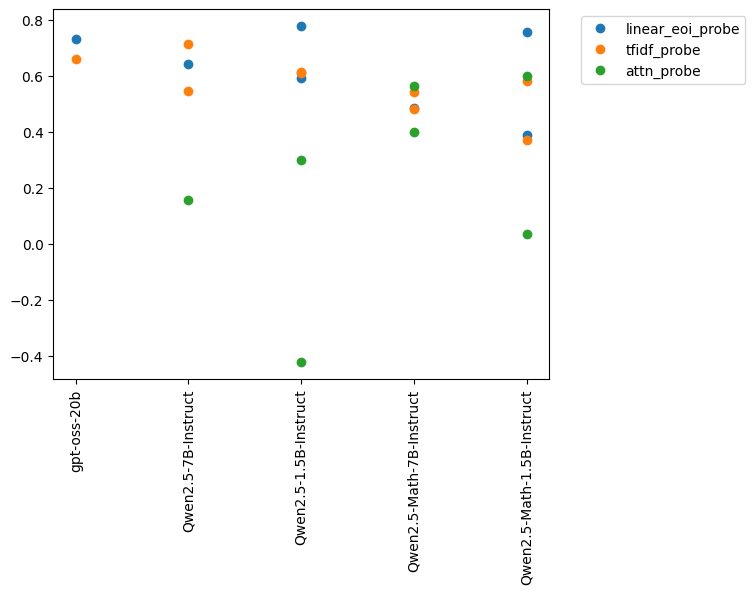

In [64]:
for probe_type in [
    'linear_eoi_probe',
    'tfidf_probe',
    'attn_probe'
]:
    rs = filter_probe_results(
        results,
        probe_type=probe_type,
    )
    xs = [r['model_variant'] for r in rs]
    ys = [r['spearman'] for r in rs]
    
    plt.plot(xs, ys, 'o', label=probe_type)

    # also print out the values
    # for x, y in zip(xs, ys):
    #     print(f"{probe_type}\t{x}\t{y}")

plt.xticks(rotation=90)
# legend outside plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [65]:
import pandas as pd

def results_to_dataframe(results):
    """
    Converts the list of result dictionaries into a pandas DataFrame.
    
    Features:
    - Converts timestamp strings to datetime objects.
    - Reorders columns so metadata (Model, Dataset, Probe) appears on the left.
    - Sorts the DataFrame by Dataset, Model, and Timestamp.

    Args:
        results (list[dict]): The list of dictionaries from load_all_probe_metrics.

    Returns:
        pd.DataFrame: A structured DataFrame containing all results.
    """
    if not results:
        return pd.DataFrame()

    df = pd.DataFrame(results)

    # 1. Convert Timestamp to datetime objects
    # The format in your file tree is YYYYMMDD_HHMMSS (e.g., 20260113_211530)
    if 'timestamp' in df.columns:
        df['datetime'] = pd.to_datetime(df['timestamp'], format='%Y%m%d_%H%M%S', errors='coerce')

    # 2. Reorder columns to put metadata first
    meta_cols = [
        'dataset', 
        'model_family', 
        'model_variant', 
        'probe_type', 
        'datetime',
        'timestamp' # Keeping original string just in case
    ]
    
    # Identify metric columns (everything that isn't metadata or the full path)
    metric_cols = [c for c in df.columns if c not in meta_cols and c != 'full_path']
    
    # Construct final column order
    final_order = meta_cols + metric_cols + ['full_path']
    
    # Filter to ensure we only ask for columns that actually exist (handling empty/partial data)
    final_order = [c for c in final_order if c in df.columns]
    
    df = df[final_order]

    # 3. Sort for readability
    sort_cols = [c for c in ['dataset', 'model_variant', 'probe_type', 'datetime'] if c in df.columns]
    df = df.sort_values(by=sort_cols, ascending=[True, True, True, False])

    return df

In [66]:
df = results_to_dataframe(results)

In [67]:
df

,dataset,model_family,model_variant,probe_type,datetime,timestamp,best_layer_idx,best_pos_idx,best_position_value,best_alpha,...,num_predicted_bin_4,precision_bin_4,recall_bin_4,f1_bin_4,learnability_ys_mean,learnability_selected_mean,learnability_best_possible_mean,model_type,metric_name,full_path
9,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-1.5B-Instruct,attn_probe,2026-01-14 16:20:20,20260114_162020,18.0,NaN,NaN,NaN,...,74.0,0.000000,0.000000,0.000000,0.120491,0.088888,0.235466,NaN,NaN,../data/results/Qwen/Qwen2.5-1.5B-Instruct/Dig...
10,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-1.5B-Instruct,linear_eoi_probe,2026-01-13 22:24:22,20260113_222422,24.0,4.0,-1.0,1000.0,...,462.0,0.759740,0.422383,0.542923,0.120491,0.173557,0.235466,NaN,NaN,../data/results/Qwen/Qwen2.5-1.5B-Instruct/Dig...
11,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-1.5B-Instruct,tfidf_probe,2026-01-13 21:38:15,20260113_213815,NaN,NaN,NaN,1.0,...,283.0,0.614841,0.209386,0.312388,0.120491,0.148581,0.235466,ridge,spearman,../data/results/Qwen/Qwen2.5-1.5B-Instruct/Dig...
5,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-7B-Instruct,tfidf_probe,2026-01-13 21:38:12,20260113_213812,NaN,NaN,NaN,1.0,...,2258.0,0.806466,0.623203,0.703089,0.071822,0.105300,0.209823,ridge,spearman,../data/results/Qwen/Qwen2.5-7B-Instruct/Digit...
21,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-Math-1.5B-Instruct,attn_probe,2026-01-14 16:20:04,20260114_162004,18.0,NaN,NaN,NaN,...,1109.0,0.857529,0.322045,0.468242,0.067980,0.107803,0.200936,NaN,NaN,../data/results/Qwen/Qwen2.5-Math-1.5B-Instruc...
20,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-Math-1.5B-Instruct,linear_eoi_probe,2026-01-13 22:20:50,20260113_222050,18.0,4.0,-1.0,10000.0,...,2559.0,0.883939,0.766001,0.820755,0.067980,0.118469,0.200936,NaN,NaN,../data/results/Qwen/Qwen2.5-Math-1.5B-Instruc...
22,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-Math-1.5B-Instruct,tfidf_probe,2026-01-13 21:33:47,20260113_213347,NaN,NaN,NaN,10.0,...,2208.0,0.837862,0.626482,0.716915,0.067980,0.096274,0.200936,ridge,spearman,../data/results/Qwen/Qwen2.5-Math-1.5B-Instruc...
15,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-Math-7B-Instruct,attn_probe,2026-01-14 16:16:37,20260114_161637,18.0,NaN,NaN,NaN,...,1010.0,0.524752,0.379656,0.440565,0.135512,0.149253,0.239335,NaN,NaN,../data/results/Qwen/Qwen2.5-Math-7B-Instruct/...
16,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-Math-7B-Instruct,tfidf_probe,2026-01-14 15:48:15,20260114_154815,NaN,NaN,NaN,1.0,...,504.0,0.607143,0.219198,0.322105,0.135512,0.151683,0.239335,ridge,spearman,../data/results/Qwen/Qwen2.5-Math-7B-Instruct/...
7,gpqa,Qwen,Qwen2.5-1.5B-Instruct,attn_probe,2026-01-14 16:04:51,20260114_160451,18.0,NaN,NaN,NaN,...,0.0,0.000000,0.000000,0.000000,0.071457,0.098767,0.152025,NaN,NaN,../data/results/Qwen/Qwen2.5-1.5B-Instruct/gpq...


In [68]:
cols = df.columns[:5].tolist() + ['spearman']
df[cols]

,dataset,model_family,model_variant,probe_type,datetime,spearman
9,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-1.5B-Instruct,attn_probe,2026-01-14 16:20:20,-0.422623
10,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-1.5B-Instruct,linear_eoi_probe,2026-01-13 22:24:22,0.777752
11,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-1.5B-Instruct,tfidf_probe,2026-01-13 21:38:15,0.609729
5,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-7B-Instruct,tfidf_probe,2026-01-13 21:38:12,0.545532
21,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-Math-1.5B-Instruct,attn_probe,2026-01-14 16:20:04,0.599425
20,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-Math-1.5B-Instruct,linear_eoi_probe,2026-01-13 22:20:50,0.755853
22,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-Math-1.5B-Instruct,tfidf_probe,2026-01-13 21:33:47,0.580942
15,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-Math-7B-Instruct,attn_probe,2026-01-14 16:16:37,0.561634
16,DigitalLearningGmbH_MATH-lighteval,Qwen,Qwen2.5-Math-7B-Instruct,tfidf_probe,2026-01-14 15:48:15,0.543471
7,gpqa,Qwen,Qwen2.5-1.5B-Instruct,attn_probe,2026-01-14 16:04:51,0.297520


In [69]:
import pandas as pd

def generate_spearman_latex(df, dataset_filter=None):
    """
    Converts the results DataFrame into a LaTeX table with:
    - Y-axis: Probe Type
    - X-axis: Model Variant
    - Final Column: Average Spearman score across models
    
    Args:
        df (pd.DataFrame): Input DataFrame containing 'probe_type', 'model_variant', 
                           and 'spearman' columns.
        dataset_filter (str, optional): If provided, filters the DF for this dataset 
                                        before generating the table.

    Returns:
        str: The generated LaTeX code.
    """
    # 1. Filter by dataset if requested
    if dataset_filter:
        df = df[df['dataset'] == dataset_filter]

    # 2. Pivot the table: Index=Probe, Columns=Model, Values=Spearman
    # aggfunc='mean' ensures that if multiple entries exist (e.g. multiple timestamps), 
    # we take the average.
    pivot_df = df.pivot_table(
        index='probe_type', 
        columns='model_variant', 
        values='spearman', 
        aggfunc='mean'
    )

    # 3. Calculate the Average across all model columns (axis 1)
    pivot_df['Average'] = pivot_df.mean(axis=1)

    # make the model variant and probe type more readable by replacing underscores with spaces
    pivot_df.index = [pt.replace('_', ' ').title() for pt in pivot_df.index]
    pivot_df.columns = [col.replace('_', ' ').title() for col in pivot_df.columns]

    # 4. Generate LaTeX
    # float_format="%.3f" rounds to 3 decimal places
    # na_rep="-" puts a dash where data is missing
    latex_code = pivot_df.to_latex(
        float_format="%.3f",
        na_rep="-",
        caption=f"Spearman Correlation by Probe Type{f' ({dataset_filter})' if dataset_filter else ''}",
        label="tab:spearman_results",
        position="h",
        column_format="l" + "c" * len(pivot_df.columns) # Left align index, center align data
    )
    
    return latex_code

In [70]:
print(generate_spearman_latex(df, dataset_filter='DigitalLearningGmbH_MATH-lighteval'))

\begin{table}[h]
\caption{Spearman Correlation by Probe Type (DigitalLearningGmbH_MATH-lighteval)}
\label{tab:spearman_results}
\begin{tabular}{lccccc}
\toprule
 & Qwen2.5-1.5B-Instruct & Qwen2.5-7B-Instruct & Qwen2.5-Math-1.5B-Instruct & Qwen2.5-Math-7B-Instruct & Average \\
\midrule
Attn Probe & -0.423 & - & 0.599 & 0.562 & 0.246 \\
Linear Eoi Probe & 0.778 & - & 0.756 & - & 0.767 \\
Tfidf Probe & 0.610 & 0.546 & 0.581 & 0.543 & 0.570 \\
\bottomrule
\end{tabular}
\end{table}

